In [4]:
!pip install --upgrade datasets==3.6.0 && pip install librosa torch matplotlib transformers
!git clone https://github.com/abdozawia20/Speech-To-Speech-Model.git
%cd Speech-To-Speech-Model

Cloning into 'Speech-To-Speech-Model'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 2.03 MiB | 7.15 MiB/s, done.
/content/Speech-To-Speech-Model


In [15]:

from dataset_loader import load_train_data, play_audio
from encoders import VQGANEncoder, Wav2VecEncoder, SpectogramEncoder
from torch.utils.data import DataLoader
from IPython.display import Audio, display
import numpy as np
import torch
import torch.nn as nn
import os
import sys # Required for sys.getsizeof
import librosa.display
import matplotlib.pyplot as plt
import random # only used for picking random records from the dataset


In [8]:
#@title Loading the dataset

dataset = load_train_data()
english_dataset = dataset['en']

random_seed = random.randint(0, 1_000_000)
shuffled_english_dataset = english_dataset.shuffle(seed=random_seed)
english_audio_record = next(iter(shuffled_english_dataset))

play_audio(english_audio_record)

Spectrogram shape: (1025, 150)
Spectogram Object: [-59.76782931 -63.13660378 -75.81654598 -60.46931481 -58.96567801
 -64.16291038 -66.16166806 -58.45499336 -63.27593172 -60.61468678]


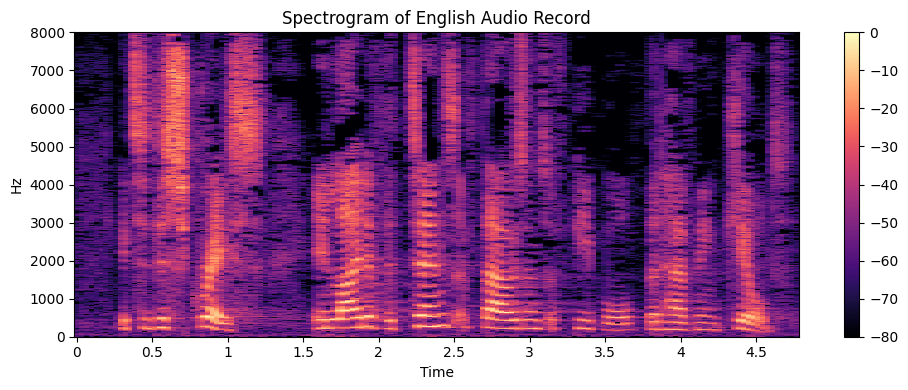

In [11]:
#@title Spectogram Usage

# Example usage with the previously loaded english_audio_record
audio_array = np.array(english_audio_record['audio']['array'])
sampling_rate = english_audio_record['audio']['sampling_rate']

spectrogram = SpectogramEncoder(audio_array, sampling_rate)

print("Spectrogram shape:", spectrogram.shape)
print("Spectogram Object:", spectrogram[1][:10])

# Optionally, display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spectrogram of English Audio Record')
plt.tight_layout()
plt.show()

Using the pretrained model "Wav2Vec 2.0" developed by Facebook/Meta. This model has already been trained on thousands of hours of speech and knows how to extract rich feature vectors from waveforms.

In [12]:
#@title Wav2Vec Usage
# 1. Instantiate the pretrained model
feature_encoder = Wav2VecEncoder(model_name="facebook/wav2vec2-base-960h")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_encoder.to(device)

try:
    # 2. Get the audio data
    # FIX: We wrap this in np.array() to ensure it is not a list
    raw_audio_numpy = np.array(english_audio_record['audio']['array'])
    orig_sampling_rate = english_audio_record['audio']['sampling_rate']

    # --- RESAMPLING ---
    target_sampling_rate = 16000

    if orig_sampling_rate != target_sampling_rate:
        print(f"Resampling from {orig_sampling_rate}Hz to {target_sampling_rate}Hz...")
        audio_input = librosa.resample(y=raw_audio_numpy, orig_sr=orig_sampling_rate, target_sr=target_sampling_rate)
    else:
        audio_input = raw_audio_numpy

    # 3. Preprocessing
    inputs = feature_encoder.processor(audio_input, sampling_rate=target_sampling_rate, return_tensors="pt")
    input_values = inputs.input_values.to(device)

    # 4. Generate the Vectors
    with torch.no_grad():
        generated_vectors = feature_encoder(input_values)

    # 5. Inspect the Output
    print(f"\nOriginal Audio Shape (Resampled): {audio_input.shape}")
    print(f"Generated Vector Shape: {generated_vectors.shape} (Batch, Latent_Time, Features)")

    print("\nThese are the Pretrained Wav2Vec latent representations.")
    print("First 10 features of the first time step:")
    print(generated_vectors[0, 0, :10])

except Exception as e:
    print(f"An error occurred: {e}")
    # This helps us debug if it happens again
    import traceback
    traceback.print_exc()

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original Audio Shape (Resampled): (76795,)
Generated Vector Shape: torch.Size([1, 239, 768]) (Batch, Latent_Time, Features)

These are the Pretrained Wav2Vec latent representations.
First 10 features of the first time step:
tensor([ 0.0071,  0.0144, -0.2511, -0.0894, -0.0974, -0.0257,  0.1278, -0.0341,
         0.2913, -0.2118])


Using the pretrained model Vector Quantized Generative Adversarial Network "VQ-GAN"(known as EnCodec) developed by Meta. Uses Vector Quantization to compress Input Audio Waveform(the audio file / the speech signal).

In [16]:
#@title VQ-GAN Usage
# 1. Instantiate the VQ-GAN (EnCodec)
vqgan_model = VQGANEncoder(model_name="facebook/encodec_24khz")
vqgan_model.to(device)

try:
    # 2. Prepare Data (EnCodec expects 24kHz)
    raw_audio_numpy = np.array(english_audio_record['audio']['array'])
    orig_sampling_rate = english_audio_record['audio']['sampling_rate']
    target_sampling_rate = 24000

    # Resample
    if orig_sampling_rate != target_sampling_rate:
        print(f"Resampling for VQ-GAN from {orig_sampling_rate}Hz to {target_sampling_rate}Hz...")
        audio_input = librosa.resample(y=raw_audio_numpy, orig_sr=orig_sampling_rate, target_sr=target_sampling_rate)
    else:
        audio_input = raw_audio_numpy

    # 3. Preprocess (Add Batch and Channel dimensions)
    # EnCodec expects: (Batch, Channels, Time) -> (1, 1, Time)
    inputs = vqgan_model.processor(raw_audio=audio_input, sampling_rate=target_sampling_rate, return_tensors="pt")
    input_values = inputs["input_values"].to(device)

    # 4. ENCODE: Audio -> Discrete Codes
    # This is the "VQ" part. We get a list of integers.
    with torch.no_grad():
        # Change 'bandwidth' here to: 1.5, 3.0, 6.0, 12.0, or 24.0. The greater the bandwidth, the better the audio output but more latent codes generated.
        # As the sequence of numbers becomes too long and complex, and the "Bridge" translation model will struggle to learn it later.
        # For example, At 1.5 kbps: For every time step, the bridge only needs to predict 2 numbers. At 24.0 kbps: For every time step, the bridge must predict 32 numbers
        encoder_outputs = vqgan_model.encode(input_values, bandwidth=6.0)
        audio_codes = encoder_outputs.audio_codes
        audio_scales = encoder_outputs.audio_scales

    # 5. DECODE: Discrete Codes -> Audio
    # This is the "GAN" part (Generator). It reconstructs sound from the numbers.
    with torch.no_grad():
        reconstructed_audio = vqgan_model.decode(audio_codes, audio_scales)

    # 6. Inspect Results
    print(f"\nOriginal Audio Shape: {input_values.shape}")
    print(f"Compressed Codes Shape: {audio_codes.shape} (Batch, Codebooks, Time_Frames)")

    print("\nThese are the Discrete Codes (The 'Language' of the Audio):")
    # We look at the first codebook, first 10 time steps
    print(audio_codes[0, 0, :20])

    # 7. Listen to the Result
    # If the VQ-GAN is working, this should sound almost identical to the original.
    print("\nPlaying Reconstructed Audio (Decoded from codes):")
    display(Audio(data=reconstructed_audio.cpu().numpy().squeeze(), rate=target_sampling_rate))

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Resampling for VQ-GAN from 16000Hz to 24000Hz...

Original Audio Shape: torch.Size([1, 1, 115193])
Compressed Codes Shape: torch.Size([1, 1, 8, 360]) (Batch, Codebooks, Time_Frames)

These are the Discrete Codes (The 'Language' of the Audio):
tensor([[ 408,  339,  475,  ...,  106,  106,  738],
        [ 544,  544,  544,  ...,  913,  544,  544],
        [ 937,  432, 1005,  ...,   36,   36,  786],
        ...,
        [ 293,  763,  505,  ...,  701,  505,  939],
        [1015,  772,  860,  ...,  900,  853,  570],
        [1012,  468,  975,  ...,  518,  383,  931]])

Playing Reconstructed Audio (Decoded from codes):
